In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
# from keras import backend as K

from scipy.stats import uniform
from scipy.stats import loguniform

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
directory = r'data/'

def readfiles(directory):
    data_files = []
    for filename in os.listdir(directory):
        temp = pd.read_csv(os.path.join(directory, filename), sep=",", header=None)
        # if filename.startswith("regular_250"): temp['label'] = 0
        # elif filename.startswith("abrupt_d_250"): temp['label'] = 1
        # elif filename.startswith("abrupt_u_250"): temp['label'] = 2
        # elif filename.startswith("anomalies_250"): temp['label'] = 3
        # elif filename.startswith("gradual_dudu_250"): temp['label'] = 4
        # elif filename.startswith("gradual_udud_250"): temp['label'] = 5
        # elif filename.startswith("incremental_d_250"): temp['label'] = 6
        # elif filename.startswith("incremental_u_250"): temp['label'] = 7
        # elif filename.startswith("incremental_d_anomaly_250"): temp['label'] = 8
        # elif filename.startswith("incremental_u_anomaly_250"): temp['label'] = 9
        # elif filename.startswith("moa_abrupt_d_250"): temp['label'] = 10
        # elif filename.startswith("moa_gradual_dudu_250"): temp['label'] = 11
        # elif filename.startswith("moa_incremental_d_250"): temp['label'] = 12
        if filename.startswith("regular_250"): 
            temp['label'] = 0
        elif filename.startswith("abrupt"): 
            temp['label'] = 1
        elif filename.startswith("anomalies"): 
            temp['label'] = 2
        elif filename.startswith("gradual"): 
            temp['label'] = 3
        elif filename.startswith("incremental"): 
            temp['label'] = 4
        if 'label' in temp.columns:
            data_files.append(temp)
    data = pd.concat(data_files, axis=0, ignore_index=True)
        
    return data

In [3]:
data = readfiles(directory)

In [4]:
print(data.shape)

(1000, 251)


In [5]:
'''
0-regular, 1-abrupt_down, 2-abrupt_up, 3-anomalies, 4-gradual_down_up_down_up, 5-gradual_up_down_up_down, 6-incremental_down, 7-incremental_up, 8-incremental_down_with_anomalies, 9-incremental_up_with_anomalies, 10-MOA_abrupt_down, 11-MOA_gradual_down_up_down_up, 12-MOA_incremental_down
'''
print(data.iloc[:,-1].nunique())

5


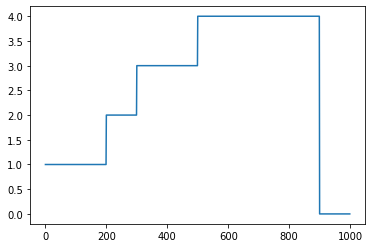

In [6]:
plt.plot(data.iloc[:,-1])

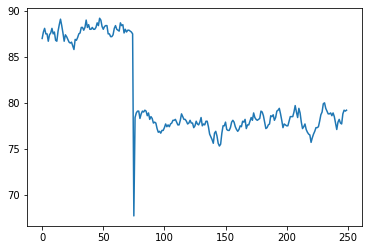

In [7]:
plt.plot(data.iloc[0,:-1])

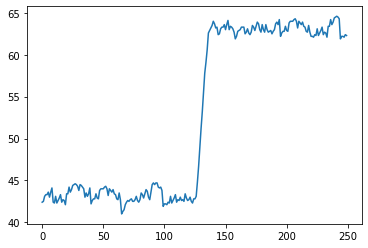

In [8]:
plt.plot(data.iloc[150,:-1])

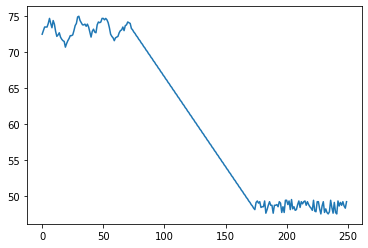

In [9]:
plt.plot(data.iloc[550,:-1])

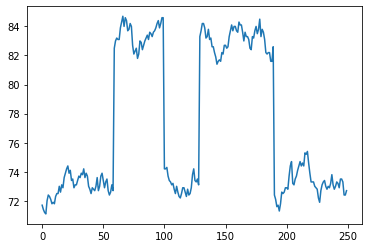

In [10]:
plt.plot(data.iloc[420,:-1])

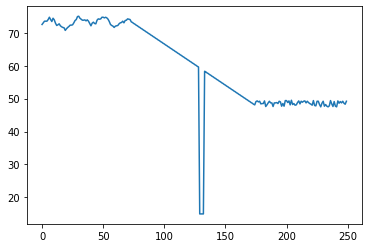

In [11]:
plt.plot(data.iloc[650,:-1])

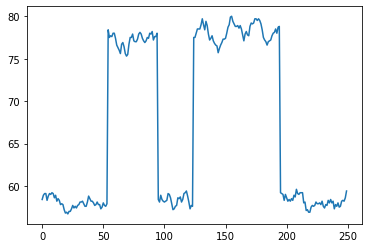

In [12]:
plt.plot(data.iloc[450,:-1])

In [13]:
data_shuffle = data.sample(frac=1).reset_index(drop=True)

In [14]:
# normalizes data
x_train = np.array(data_shuffle.iloc[:,:-1])
y_train = np.array(data_shuffle.iloc[:,-1])
min_max_scaler = preprocessing.MinMaxScaler()
x_train_normalized = [min_max_scaler.fit_transform(x_train[i].reshape(-1,1)) for i in range(x_train.shape[0])]

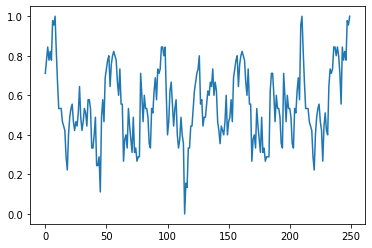

In [15]:
plt.plot(x_train_normalized[0])

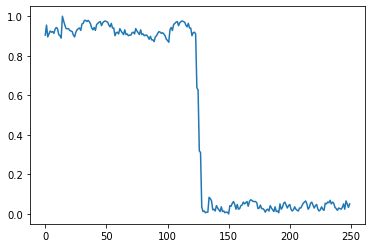

In [16]:
plt.plot(x_train_normalized[561])

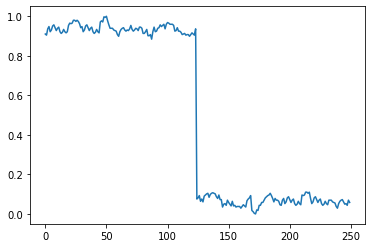

In [17]:
plt.plot(x_train_normalized[15])

In [18]:
# convert back to np arrays from normalization, y reshaped y.shape(1)
X = np.array(x_train_normalized)
y = np.array(y_train)
y = y.reshape(len(y), 1)

In [19]:
print(X.shape)
print(y.shape)

(1000, 250, 1)
(1000, 1)


In [20]:
# one hot encoding e.g. type 1 = [0,1,0,0,0,0]
y_one_hot = to_categorical(y)
print(y_one_hot.shape)

(1000, 5)


In [21]:
# global variables
neurons=64
batch_size=50
epoch_size=2
clipnorm=6
patience=3
dropout=0.2

In [22]:
def build_model(X, y, neurons=32, return_sequence=True, batch_size=1, shuffle=True, stateful=True, epoch_size=1000, clipnorm=1, patience=3, verbose=0):
    histories_val_loss, histories_val_acc = [], []
    best_min_val_loss = float('inf')
    counter = 0
    best_weights = []
    
    model = Sequential()
    # print(batch_size)
#     Stateful LSTM
    model.add(Bidirectional(LSTM(neurons, return_sequences=return_sequence, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=stateful, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(int(neurons/2), dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(clipnorm=clipnorm), metrics=['accuracy'])
    for i in range(epoch_size):
        if counter >= patience: break
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=verbose, shuffle=shuffle, validation_split=0.2)
#         print(model.history.history['val_loss'])
        if model.history.history['val_loss'][0] < best_min_val_loss:
            best_min_val_loss = model.history.history['val_loss'][0]
            best_weights = model.get_weights()
            counter = 0
            print("epoch " + str(i) + ": ", best_min_val_loss, counter)
        else:
            counter += 1
            print("epoch " + str(i) + ": ", best_min_val_loss, counter)
        histories_val_loss.append(model.history.history['val_loss'])
        histories_val_acc.append(model.history.history['val_accuracy'])
        model.reset_states()
        
    model.set_weights(best_weights)
#     model.summary()
        
    return model, histories_val_loss, histories_val_acc # for stateful lstm

    # stateless LSTM
#     model.add(Bidirectional(LSTM(neurons, return_sequences=return_sequence,
#                                  input_shape=(X.shape[1], X.shape[2]), dropout=0.2, recurrent_dropout=0.2)))
#     model.add(Bidirectional(LSTM(int(neurons/2), dropout=0.2, recurrent_dropout=0.2)))
#     model.add(Dense(y.shape[1], activation='softmax'))
#     model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.Adam(clipnorm=clipnorm),
#                   metrics=['accuracy'])
#     model.fit(X, y, epochs=epoch_size, batch_size=batch_size, verbose=verbose, shuffle=shuffle, validation_split=0.2,
#                     callbacks=[EarlyStopping(monitor='val_loss', patience=patience, mode='min')])

#     return model # for stateless lstm

In [23]:
def return_optimizer(type, clipnorm, learning_rate):
    if type == 'Adam':
        return keras.optimizers.Adam(clipnorm=clipnorm, learning_rate=learning_rate)
    elif type == 'SGD':
        return keras.optimizers.SGD(clipnorm=clipnorm, learning_rate=learning_rate)
    elif type == 'RMSprop':
        return keras.optimizers.RMSprop(clipnorm=clipnorm, learning_rate=learning_rate)
    elif type == 'Nadam':
        return keras.optimizers.Nadam(clipnorm=clipnorm, learning_rate=learning_rate)
    elif type == 'Adadelta':
        return keras.optimizers.Adadelta(clipnorm=clipnorm, learning_rate=learning_rate)

In [24]:
def build_model_gridsearch_stateful(optimizer='Adam', neurons=32, clipnorm=1, dropout=0.2, learning_rate=0.0001):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=True, dropout=dropout, recurrent_dropout=dropout)))
    model.add(Bidirectional(LSTM(int(neurons/2), dropout=dropout, recurrent_dropout=dropout)))
    model.add(Dense(y_one_hot.shape[1], activation='softmax'))
    opt = return_optimizer(type=optimizer, clipnorm=clipnorm, learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        
    return model

In [25]:
def build_model_gridsearch_stateless(optimizer='Adam', neurons=32, clipnorm=1, dropout=0.2, learning_rate=0.0001):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, return_sequences=True, input_shape=(X.shape[1], X.shape[2]), dropout=dropout, recurrent_dropout=dropout)))
    model.add(Bidirectional(LSTM(int(neurons/2), dropout=dropout, recurrent_dropout=dropout)))
    model.add(Dense(y_one_hot.shape[1], activation='softmax'))
    opt = return_optimizer(type=optimizer, clipnorm=clipnorm, learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        
    return model

In [26]:
def grid_search_cv(X, y, batch_size=batch_size, epoch_size=epoch_size):
    model = KerasClassifier(build_fn=build_model_gridsearch_stateful, epochs=epoch_size, batch_size=batch_size, verbose=0)
    param_grid = {
        'epochs': [50],
        # 'batch_size': [50],
        'optimizer': ['Adam', 'SGD', 'Nadam', 'Adadelta', 'RMSprop'],
        'clipnorm': [6],
        'neurons': [64],
        'learning_rate': [0.001],
        'dropout': [0.2]
    }   
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=2) # -1 for n_jobs means using all processor and runs in parallel, 1 turns this off
    grid_result = grid.fit(X, y)   
    return grid_result.cv_results_ # returns all the results of the grid search run 
    # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # means = grid_result.cv_results_['mean_test_score']
    # stds = grid_result.cv_results_['std_test_score']
    # params = grid_result.cv_results_['params']
    # for mean, stdev, param in zip(means, stds, params):
    #     print("%f (%f) with: %r" % (mean, stdev, param))

In [27]:
def random_grid_search_cv(X, y, batch_size=batch_size, epoch_size=epoch_size):
    model = KerasClassifier(build_fn=build_model_gridsearch_stateless, epochs=epoch_size, batch_size=batch_size, verbose=0)
    param_grid = {
        'epochs': [i for i in range(0,4,2)],
        'batch_size': [i for i in range(0,250,50)],
        'optimizer': ['Adam', 'SGD', 'Nadam', 'Adadelta', 'RMSprop'],
        'clipnorm': [i for i in range(1,16)],
        'neurons': [i*32 for i in range(1,4)],
        'learning_rate': loguniform(1e-5, 10)
    }   
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=3, n_jobs=-1, cv=5, verbose=2) # -1 for n_jobs means using all processor and runs in parallel, 1 turns this off
    grid_result = grid.fit(X, y)   
    return grid_result.cv_results_ # returns all the results of the grid search run 
    # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # means = grid_result.cv_results_['mean_test_score']
    # stds = grid_result.cv_results_['std_test_score']
    # params = grid_result.cv_results_['params']
    # for mean, stdev, param in zip(means, stds, params):
    #     print("%f (%f) with: %r" % (mean, stdev, param))

In [28]:
def eval_model(model, X, y, batch_size=1):
    score = model.evaluate(X, y, batch_size, verbose=0)
    print("Model Accuracy: ", score[1]*100)

In [29]:
def predict(model, X):
    X = X.reshape(1, X.shape[0], 1)
    yhat = model.predict(X, verbose=0)
    return yhat

In [30]:
grid_cv_results = grid_search_cv(X, y_one_hot, batch_size, epoch_size)
# random_grid_search_cv(X, y_one_hot, batch_size, epoch_size)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
'''
These are the values saved in the csv for each combination of parameters run in the grid search:
mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clipnorm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score

mean_fit_time - average time over the k folds for training
mean_score_time - average time over the k folds for predictions (testing)
params - the combination of parameters used in this iteration of gridsearch
split test score is each individual accuracy score for each fold
mean_test_score - weighted average over the k folds for accuracy results
rank_test_score - rank of this combination of parameters based on mean_test_score, 1 to n number of combinations, 1 being the best, n being the worst
'''
def toCSV(cv_results):
    df = pd.DataFrame(cv_results)
    df.to_csv('grid_search_results.csv', index=False)

In [ ]:
toCSV(grid_cv_results)

In [ ]:
# model = build_model(X, y_one_hot, neurons=neurons, return_sequence=True, shuffle=False, batch_size=batch_size, epoch_size=epoch_size, clipnorm=clipnorm, patience=patience, verbose=2) # for stateless lstm

# model, histories_loss, histories_acc = build_model(X, y_one_hot, neurons=neurons, return_sequence=True, shuffle=False, batch_size=batch_size, epoch_size=epoch_size, clipnorm=clipnorm, patience=patience, verbose=2) # for stateful lstm

In [ ]:
# norm = sqrt(sum(np.sum(K.get_value(w)) for w in model.optimizer.weights)) 
# print(norm)

In [ ]:
plt.plot(histories_loss) # for stateful lstm
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.title("epoch vs val loss with patience=250, clipnorm=6, stateful")

# plt.plot(model.history.history['val_loss'])
# plt.xlabel("epoch")
# plt.ylabel("validation loss")
# plt.title("epoch vs val loss with patience=15, clipnorm=6")

In [ ]:
plt.plot(histories_acc) # for stateful lstm
plt.xlabel("epoch")
plt.ylabel("validation accuracy")
plt.title("epoch vs val acc with patience=250, clipnorm=6, stateful")

# plt.plot(model.history.history['val_accuracy'])
# plt.xlabel("epoch")
# plt.ylabel("validation accuracy")
# plt.title("epoch vs val accuracy with patience=15, clipnorm=6")

In [ ]:
# overall accuracy score of the model trained
score = eval_model(model, X, y_one_hot, batch_size=batch_size)

In [ ]:
# re-define the batch size, this is used for stateful LSTM
# neurons=64
# change to batch_size=1 for prediction
# clipnorm=6
def redefineStatefulModelWithBatchSizeOne(model, X, y_one_hot, clipnorm, neurons):
    new_model = Sequential()
    batch_input_shape=(1, X.shape[1], X.shape[2])
    new_model.add(Bidirectional(LSTM(neurons, return_sequences=True, 
                    stateful=True, dropout=0.2, recurrent_dropout=0.2)))
    new_model.add(Bidirectional(LSTM(int(neurons/2), dropout=0.2, recurrent_dropout=0.2)))
    new_model.add(Dense(y_one_hot.shape[1], activation='softmax'))

    new_model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(clipnorm=clipnorm),
                metrics=['accuracy'])

    new_model.build(batch_input_shape)

    # copy weights
    new_model.set_weights(model.get_weights())
    return new_model
    # new_model.summary()

In [ ]:
# iterates through each of the sample in the normalized dataset
# passes the sample and the new model into the predict function
def predictTest(model, testDataNormalized):
    predictions = []

    for row in testDataNormalized:
        prediction = predict(model, row) 
        predictions.append(prediction)

    return predictions

In [ ]:
new_model = redefineStatefulModelWithBatchSizeOne(model, X, y_one_hot, clipnorm, neurons) # for stateful
predictions = predictTest(new_model, x_train_normalized)

In [ ]:
print(predictions) # gives probability of each class

In [ ]:
# translates predictions (probabilities) into labels (getting largest probability in the array)
labels = np.argmax(predictions, axis=-1) 
# print(labels)

In [ ]:
values, counts = np.unique(labels, return_counts=True)
print(values)
print(counts)

Legend:
0-regular, 1-abrupt_down, 2-abrupt_up, 3-anomalies, 4-gradual_down_up_down_up, 5-gradual_up_down_up_down, 6-incremental_down, 7-incremental_up, 8-incremental_down_with_anomalies, 9-incremental_up_with_anomalies, 10-MOA_abrupt_down, 11-MOA_gradual_down_up_down_up, 12-MOA_incremental_down

## For Testing Other Inputs ##

In [ ]:
windowSize=250
dataStreamFile = "test_10x250.csv"

In [ ]:
def sliceDatastream(filename, windowSize=50):
    directory = r'test/'
    windows = []
    test_filename_path = os.path.join(directory + filename)
    with open(test_filename_path, newline='') as csvfile:
        data = list(csv.reader(csvfile))[0]

    n = len(data)

    for i in range(0, n, windowSize):
        temp = np.array(data[i:i+windowSize])
        if i+windowSize < len(data): windows.append(temp)
        
    return windows

In [ ]:
def plotDataStream(sliced, windowSize=50, ncol=5, withLabel=False, labels=None):
    n = len(sliced)
    remainder = n%5
    nRows = n/ncol if remainder == 0 else n/ncol + 1
    if withLabel: 
        figure = make_subplots(rows=int(nRows), cols=ncol, subplot_titles=[labels[i] for i in range(n)])
    else:
        figure = make_subplots(rows=int(nRows), cols=ncol, subplot_titles=[("window - "+str(i)) for i in range(n)])

    for i in range(n):
        if withLabel: figure.add_trace(go.Scatter(name="window - "+str(i), x=[j+windowSize*i for j in range(windowSize)], y=sliced[i]), row=int((i/ncol+1)), col=int((i%ncol+1)))
        else: figure.add_trace(go.Scatter(name="window - "+str(i), x=[j+windowSize*i for j in range(windowSize)], y=sliced[i]), row=int((i/ncol+1)), col=int((i%ncol+1)))
        figure.update_xaxes(title_text="timestep", row=int((i/ncol+1)), col=int((i%ncol+1)))
        figure.update_yaxes(title_text="value", row=int((i/ncol+1)), col=int((i%ncol+1)))

    figure.update_layout(height=600, width=1500, title_text="DataStream, window size: "+str(windowSize))
    figure.show()

In [ ]:
def plotPercentages(percentages, labels, ncol=5):
    n = len(percentages)
    formatted_percentages = []
    for i in range(n):
        oneRow = []
        for j in range(len(percentages[i][0])):
            oneRow.append(round(percentages[i][0][j]*100,2))
        formatted_percentages.append(oneRow)

    remainder = n%5
    nRows = n/ncol if remainder == 0 else n/ncol + 1
    figure = make_subplots(rows=int(nRows), cols=ncol, subplot_titles=[("window - "+str(i)) for i in range(n)], specs=[[{"type": "pie"} for i in range(ncol)] for i in range(int(nRows))])
    for i in range(n):
        figure.add_trace(go.Pie(name="window - "+str(i), values=formatted_percentages[i], labels=labels, domain=dict(x=[i%5/5, i%5/5+0.2])), row=int((i/ncol+1)), col=int((i%ncol+1)))

    figure.update_layout(height=600, width=1500, title_text="percentages of class for each window")
    figure.show()
        

In [ ]:
test_data_sliced = sliceDatastream(dataStreamFile, windowSize=windowSize)
plotDataStream(test_data_sliced, windowSize=windowSize)

In [ ]:
def getPercentages(predictions, driftname):
    result = []
    for i in range(len(predictions)):
        probabilities = predictions[i][0]
        label = ""
        for index, prob in enumerate(probabilities):
            if index < len(probabilities)-1: label += driftname[index]+str(round(prob*100,2))+"%, "
            else: label += driftname[index]+str(round(prob*100,2))+"%"
        result.append(label)
    return result

In [ ]:
def feedToModel(sliced, model, windowSize=50):
    windows = np.array(sliced)
    windows_normalized = [min_max_scaler.fit_transform(windows[i].reshape(-1,1)) for i in range(windows.shape[0])]
    windows_normalized = np.array(windows_normalized)
    predictions = predictTest(model, windows_normalized)

    labels = np.argmax(predictions, axis=-1) 
    # new_values, new_counts = np.unique(labels, return_counts=True)
    # print(new_values, new_counts)

    driftname = ["0-regular", "1-abrupt", "2-anomalies", "3-gradual", "4-incremental"]

    labelWithNames = [driftname[int(labels[i])] for i in range(len(labels))]
    
    plotDataStream(sliced, windowSize, withLabel=True, labels=labelWithNames)
    plotPercentages(predictions, driftname)


In [ ]:
feedToModel(test_data_sliced, new_model, windowSize=windowSize)

In [ ]:
def drift_detection(datafile):
    # test drifts

    new_filename = os.path.join('../test/' + datafile)
    new_datastream = pd.read_csv(os.path.join(directory, new_filename), sep=",", header=None)
    newX = np.array(new_datastream)
    newX_normalized = [min_max_scaler.fit_transform(newX[i].reshape(-1,1)) for i in range(newX.shape[0])]
    newX_normalized = np.array(newX_normalized)
    print(newX_normalized.shape)

    # array of predictions
    new_predictions = []
    # predicting the type for drift for each sample(window) in the file
    for row in newX_normalized: # the model here is the model trained above
    #     prediction = predict(model, row) # for stateless lstm
        prediction = predict(new_model, row)
        new_predictions.append(prediction)

    print(new_predictions)

    new_labels = np.argmax(new_predictions, axis=-1) 

    new_values, new_counts = np.unique(new_labels, return_counts=True)
    driftname = ["0-regular", "1-abrupt_down", "2-abrupt_up", "3-anomalies", "4-gradual_down_up_down_up", "5-gradual_up_down_up_down", "6-incremental_down", "7-incremental_up", "8-incremental_down_with_anomalies", "9-incremental_up_with_anomalies", "10-MOA_abrupt_down", "11-MOA_gradual_down_up_down_up", "12-MOA_incremental_down"]

    print(driftname[int(new_values)])
    print(new_counts)

    # plot

    plt.plot(new_datastream.T)
    plt.xlabel("timestep")
    plt.ylabel("value")
    plt.title(driftname[int(new_values)])



In [ ]:
'''
calls drift detection model
insert various data file
 
'''
# drift_detection('test_regular_250.csv')               ## 0-Regular
# drift_detection('test_abrupt_d_250.csv')              ## 1-Abrupt Drift Down
# drift_detection('test_abrupt_u_250.csv')              ## 2-Abrupt Drift Up
# drift_detection('test_anomalies_250.csv')             ## 3-Anomalies
# drift_detection('test_gradual_dudu_250.csv')          ## 4-Gradual Drift Down Up Down Up
# drift_detection('test_gradual_udud_250.csv')          ## 5-Gradual Drift Up Down Up Down
# drift_detection('test_incremental_d_250.csv')         ## 6-Incremental Down
# drift_detection('test_incremental_u_250.csv')         ## 7-Incremental Up
# drift_detection('test_incremental_d_anomaly_250.csv') ## 8-Incremental Down with Anomaly
# drift_detection('test_incremental_u_anomaly_250.csv') ## 9-Incremental Up with Anomaly ---> not always accurate depending on the magnitude of the anomaly

#### MOA DATASTREAMS ####
# drift_detection('test_moa_incremental_d_250.csv')     ## 10-(aka moa gradual) 
# drift_detection('test_moa_abrupt_d_250.csv')          ## 11-MOA Abrupt Drift Down
drift_detection('test_moa_gradual_dudu_250.csv')      ## 12-(aka moa incremental)
